## Exploring the relationship between syringomyelia symptoms and barometric pressure

The goal of this project was to assess if changes in barometric pressure have a noticeable impact on the pain levels of an individual suffering from syringomyelia. Such knowledge would be valuable to an individual who wants to make an informed decision about which cities would have the most comfortable climate for them. In this case, the data was recorded in Austin, Texas, USA.

**The project consists of the following parts:**
- Recording raw barometric pressure data to an SD card using an arduino module and a BME280 atmospheric sensor.
- Logging symptoms using a journal in google sheets.
- Calculating pressure changes over a chosen window of time.
- Determining the largest pressure changes within a chosen window of time surrounding each symptom event.
- Comparing to a baseline set of maximum pressure variations over random intervals where no symptom was reported.

**Import relevant packages:**

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import timedelta
from matplotlib import rcParams
import random
import seaborn as sb
import glob
import csv
%matplotlib inline

**Import the atmospheric data from the last period of measurement.** 

An arduino module connected to an SD card reader was programmed to log atmospheric temperature, pressure, and humidity at a rate of one reading per minute into a .txt file (VALUES.txt). 

I typically transferred the VALUES.txt file from the SD card to computer every 1-2 days, each time restarting the recording process (and creating a new .txt file).

Since the arduino module doesn't contain a clock, the measurement start time must be recorded, in order to calibrate the readings when the data is imported.

In [2]:
# Import data from the .txt file produced by the arduino module.

values = pd.read_csv(r"C:\Users\Owner\Documents\Arduino\VALUES.txt",delimiter=",")

# Input the start time of the current set of measurements so the time column can be calibrated.

start_time = ['04.07.2020 9:23:00 AM']
times = [pd.to_datetime(start_time) +timedelta(minutes=1*i) for i in range(0,len(values))]
m = pd.DataFrame(times,columns = ['Time'])

m['Temperature (deg F)']=values.iloc[:,0]
m['Pressure (hPa)']=values.iloc[:,1]
m['Humidity (%)']=values.iloc[:,2]
m=m.set_index('Time',drop=True)
m.head()

,Temperature (deg F),Pressure (hPa),Humidity (%)
Time,,,
2020-04-07 09:23:00,72.86,995.36,85.26
2020-04-07 09:24:00,72.95,995.37,85.11
2020-04-07 09:25:00,73.02,995.28,85.09
2020-04-07 09:26:00,73.08,995.28,85.03
2020-04-07 09:27:00,73.11,995.28,84.96


**Visualize the atmospheric data:**

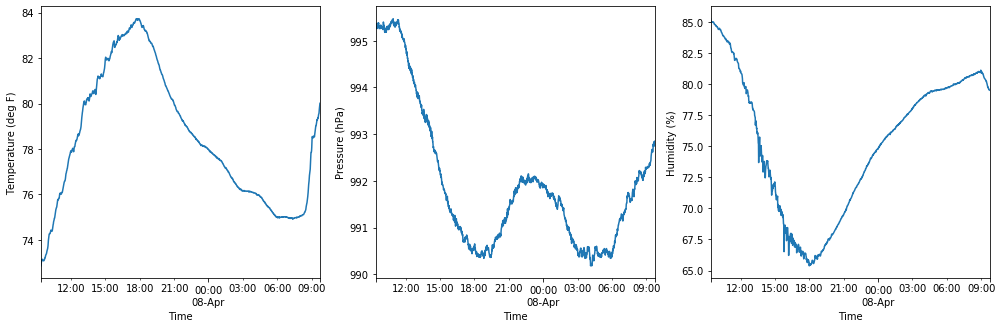

In [3]:
rcParams['figure.figsize'] = 17,5
plt.subplot(131)
m.iloc[:,0].plot()
plt.ylabel('Temperature (deg F)');
plt.subplot(132)
m.iloc[:,1].plot()
plt.ylabel('Pressure (hPa)');
plt.subplot(133)
m.iloc[:,2].plot()
plt.ylabel('Humidity (%)');

**Export the data to a .csv file.**

In [4]:
export_values = m.to_csv(r'C:\\Users\\Owner\\Documents\\Arduino\\values_04-07-2020_9-23.csv')

**Importing the symptoms data.**

Symptoms are recorded in a google sheet file, which can be downloaded as .csv for easy importing.

In [5]:
# Import the csv file as a dataframe.

symptoms = pd.read_csv(r"C:\Users\Owner\Documents\Arduino\Symptoms.csv",delimiter=",")

# Combine the date and time columns in order to create a datetime column in the same format as for the atmospheric data.

symptoms['Timestamp'] = symptoms.apply(lambda x: pd.to_datetime(x['Date'] + ' ' + x['Time']),axis=1)

# Remove the sixth column as it contains irrelevant information

symptoms = symptoms.drop(symptoms.columns[5],axis=1)
symptoms.head()

,Date,Time,Location,Strength,Notes,Timestamp
0,01/17/2020,06:30,Knees,3.0,Ache,2020-01-17 06:30:00
1,01/17/2020,18:10,Left Hand,3.0,Tingle,2020-01-17 18:10:00
2,01/18/2020,06:00,Left Foot,4.0,Twitch,2020-01-18 06:00:00
3,01/20/2020,06:20,Knees,3.0,Ache,2020-01-20 06:20:00
4,01/20/2020,21:00,Left Arm,2.0,Twitch,2020-01-20 21:00:00


**Combining all weather measurements into a single file.**

All the individual .csv files need to be combined into a single table. This enables us to look up the atmospheric conditions at the time that a symptom was recorded.

In [6]:
delimiter = ','
csvs = glob.glob('C:\\Users\\Owner\\Documents\\Arduino\\weather\\*.csv')
combined_csv = pd.concat([pd.read_csv(f) for f in csvs])
combined_csv = combined_csv.reset_index()
combined_csv['Time'] = combined_csv.apply(lambda x: pd.to_datetime(x['Time']),axis=1)
combined_csv.tail()

C:\Users\Owner\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,index,Humidity (%),Pressure (hPa),Pressure change (hPa/min),Temperature (deg F),Time
100673,1406,74.11,992.05,NaN,64.83,2020-04-02 08:53:00
100674,1407,74.13,992.02,NaN,64.87,2020-04-02 08:54:00
100675,1408,74.16,992.14,NaN,64.90,2020-04-02 08:55:00
100676,1409,74.16,992.19,NaN,64.92,2020-04-02 08:56:00
100677,1410,74.19,992.24,NaN,64.96,2020-04-02 08:57:00


**Determine the atmospheric conditions at the time the symptom was reported:**

This can be done by merging the atmospheric data with the symptoms dataframe, on the timestamp columns. Before the merge is made, a new column is added which calculates the pressure change over a 1 hour interval, centred on a given time. 

In [7]:
# The size of the window over which to measure a pressure change (in minutes)
sample_min = 60

# Calculate the pressure change with the window centred on a given time
combined_csv['Pressure change (hPa/hour)'] = np.array([0]*int(sample_min/2) + [combined_csv.iloc[i+sample_min,1] - combined_csv.iloc[i,1] for i in range(0,len(combined_csv)-sample_min)] + [0]*int(sample_min/2))

# Perform the merge
symp_pres = pd.merge(symptoms, combined_csv, left_on = 'Timestamp', right_on = 'Time')
symp_pres.head()

,Date,Time_x,Location,Strength,Notes,Timestamp,index,Humidity (%),Pressure (hPa),Pressure change (hPa/min),Temperature (deg F),Time_y,Pressure change (hPa/hour)
0,01/17/2020,06:30,Knees,3.0,Ache,2020-01-17 06:30:00,829,83.25,1001.72,NaN,55.26,2020-01-17 06:30:00,-0.08
1,01/17/2020,18:10,Left Hand,3.0,Tingle,2020-01-17 18:10:00,600,78.61,998.69,NaN,59.20,2020-01-17 18:10:00,0.59
2,01/18/2020,06:00,Left Foot,4.0,Twitch,2020-01-18 06:00:00,1310,84.29,998.62,NaN,63.28,2020-01-18 06:00:00,0.07
3,01/20/2020,21:00,Left Arm,2.0,Twitch,2020-01-20 21:00:00,720,34.10,1010.05,NaN,50.45,2020-01-20 21:00:00,2.56
4,01/20/2020,21:00,Left Hand,3.5,Tingle,2020-01-20 21:00:00,720,34.10,1010.05,NaN,50.45,2020-01-20 21:00:00,2.56


However, this only gives us the atmospheric conditions at precisely the moment that the symptom was recorded. The individual is not likely to instantly feel the effects of a weather change, so we can extend the range of interest to a 6 hr time frame centred on the recorded time. 

We calculate the maximum and minimum pressure changes during this window, and add them as new columns to the dataframe.

To accomplish this, we **define two new functions:**

In [8]:
def get_max_change(df, centre_time, plusminus):
    # returns the maximum pressure change over a given time interval (plusminus) centred on time centre_time
    location1 = df.loc[df['Time']==centre_time-plusminus].index[0]
    location2 = df.loc[df['Time']==centre_time+plusminus].index[0]
    return df.loc[location1:location2]['Pressure change (hPa/hour)'].max()

def get_min_change(df, centre_time, plusminus):
    # returns the minimum pressure change over a given time interval (plusminus) centred on time centre_time
    location1 = df.loc[df['Time']==centre_time-plusminus].index[0]
    location2 = df.loc[df['Time']==centre_time+plusminus].index[0]
    return df.loc[location1:location2]['Pressure change (hPa/hour)'].min()

Before we apply these functions to the dataframe, it is essential to know if recordings even exist for these time periods! Despite my diligence with recording, there were some days where I either forgot to switch on the sensor, or was out of town. 

**We can filter out symptom recordings which do not have corresponding weather data by using the .isin method on the atmospheric dataframe (combined_csv).**

Then, it is safe to go ahead and apply the functions above.

In [9]:
# Define the time window
plusminus = timedelta(hours = 3)

# Filter out symptom entries with no corresponding weather data
symp_pres = symp_pres[(symp_pres['Timestamp'].sub(plusminus)).isin(combined_csv['Time'])]
symp_pres = symp_pres[(symp_pres['Timestamp'].add(plusminus)).isin(combined_csv['Time'])]

# Calculate maximum and minimum pressure changes within the time window
symp_pres['Max Change 3 hr']=symp_pres.apply(lambda x: get_max_change(combined_csv, x['Timestamp'], plusminus), axis=1)
symp_pres['Min Change 3 hr']=symp_pres.apply(lambda x: get_min_change(combined_csv, x['Timestamp'], plusminus), axis=1)
symp_pres.head()

,Date,Time_x,Location,Strength,Notes,Timestamp,index,Humidity (%),Pressure (hPa),Pressure change (hPa/min),Temperature (deg F),Time_y,Pressure change (hPa/hour),Max Change 3 hr,Min Change 3 hr
0,01/17/2020,06:30,Knees,3.0,Ache,2020-01-17 06:30:00,829,83.25,1001.72,NaN,55.26,2020-01-17 06:30:00,-0.08,0.67,-1.20
1,01/17/2020,18:10,Left Hand,3.0,Tingle,2020-01-17 18:10:00,600,78.61,998.69,NaN,59.20,2020-01-17 18:10:00,0.59,0.91,-1.86
2,01/18/2020,06:00,Left Foot,4.0,Twitch,2020-01-18 06:00:00,1310,84.29,998.62,NaN,63.28,2020-01-18 06:00:00,0.07,0.79,0.03
3,01/20/2020,21:00,Left Arm,2.0,Twitch,2020-01-20 21:00:00,720,34.10,1010.05,NaN,50.45,2020-01-20 21:00:00,2.56,10.74,-2.60
4,01/20/2020,21:00,Left Hand,3.5,Tingle,2020-01-20 21:00:00,720,34.10,1010.05,NaN,50.45,2020-01-20 21:00:00,2.56,10.74,-2.60


Now we have information about the largest pressure changes which occurred at similar times to the symptom entry. However, we have no way of knowing if these pressure changes are out of the ordinary, or if they occur extremely regularly. 

It is therefore important to get a measure of pressure variation on days that no symptoms were recorded, i.e. a control dataset. This will enable us to see if large pressure changes and recorded symptoms are statistically correlated.

**To generate the control data, gaps in the symptoms diary greater than the chosen time window (6 hours) were first identified. From these, a random selection of timeslots were chosen, and the corresponding maximum/minimum pressure changes in a 6 hour time window surrounding each were recorded.**

In [10]:
# List the times that a symptom was recorded

times = [i for i in symp_pres['Timestamp']]

# Define gaps between recordings to be measured from the edges of each respective time window, defined by 2*plusminus

gaps = []
for j in range(0,2*len(times)):
    if j % 2 == 0:
        gaps.append(times[int(float(j)/2)] - plusminus)
    else:
        gaps.append(times[int(float(j-1)/2)] + plusminus)

# Calculate the duration of these gaps between recordings  

gaptimes = [gaps[i]-gaps[i-1] for i in range(1,len(gaps))]


# Find the index of gaps which are sufficiently long enough to encompass at least one full time window 
# If the gap is long enough, find how many full time windows fit in that gap

idgs = [i for i, gap in enumerate(gaptimes) if gap > 2*plusminus]
num_slots = [int(np.floor(gap / (2*plusminus))) for gap in gaptimes if gap > 2*plusminus]

# Return a list of suitable slot times to generate the control data

slot_times = []
for i, idg in enumerate(idgs):
    z = num_slots[i]
    for j in range(0,z):
        slot_times.append((gaps[idg] + j*2*plusminus) + plusminus)

The size of the control dataset needs to be the same as the symptoms dataset. Also, we need to check again if atmospheric data exists for the chosen timeslots. 

**This is achieved by defining the control dataframe, filtering out incomplete timeslots, and selecting a random subset of timeslots using the random.sample function. Then, the get_max_change and get_min_change functions can be applied to generate the control atmospheric data**

In [14]:
# Define the control dataframe

control = pd.DataFrame({'Time': np.array(slot_times)})

# Filter out incomplete data

control = control[(control['Time'].sub(plusminus)).isin(combined_csv['Time'])]
control = control[(control['Time'].add(plusminus)).isin(combined_csv['Time'])]
control = control.reset_index(drop=True)

# Drop a random selection of timeslots so the dataframe is the same size as the symp_pres dataframe

control = control.drop(random.sample(range(1,len(control)), len(control)-len(symp_pres)))

# Generate the atmospheric data

control['Max Change 3 hr control']=control.apply(lambda x: get_max_change(combined_csv, x['Time'], plusminus), axis=1)
control['Min Change 3 hr control']=control.apply(lambda x: get_min_change(combined_csv, x['Time'], plusminus), axis=1)
control.head()

,Time,Max Change 3 hr control,Min Change 3 hr control
0,2020-01-18 12:00:00,4.95,-19.71
3,2020-01-19 06:00:00,5.00,-9.30
6,2020-01-21 09:00:00,6.15,-8.44
7,2020-01-21 15:00:00,2.43,-8.11
12,2020-01-23 22:30:00,3.08,1.05


Time to have a look at the data! Lets use a boxlot to look at the distribution of positive pressure changes both when symptoms are present and absent.

Text(0, 0.5, 'Pressure change (hPa/hour)')

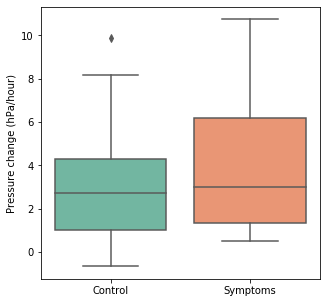

In [16]:
rcParams['figure.figsize'] = 5,5
comparison_pos = pd.DataFrame()
comparison_pos['Control'] = control['Max Change 3 hr control']
comparison_pos['Symptoms'] = symp_pres['Max Change 3 hr']
comparison_pos.head()
sb.boxplot(data=comparison_pos, palette = 'Set2')
plt.ylabel("Pressure change (hPa/hour)")

It looks the pressure increases in the time window surrounding the reporting of a symptom are indeed larger than average! Now lets do the same thing for negative pressure changes (pressure drops). 

Text(0, 0.5, 'Pressure change (hPa/hour)')

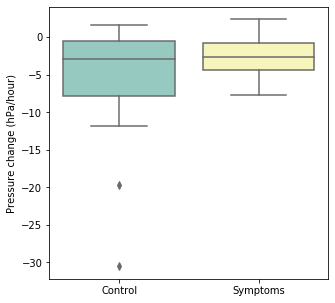

In [18]:
comparison_neg = pd.DataFrame()
comparison_neg['Control'] = control['Min Change 3 hr control']
comparison_neg['Symptoms'] = symp_pres['Min Change 3 hr']
comparison_neg.head()
sb.boxplot(data=comparison_neg, palette = 'Set3')
plt.ylabel("Pressure change (hPa/hour)")

Interestingly, it doesn't look like the same behaviour is observed for negative pressure changes. In contrast, the pressure was generally dropping less than average at the time a symptom was recorded. This could possibly indicate that pressure increases ilicit a stronger symptom response than pressure decreases.

**Next steps:**

It seems that our inital hypothesis, that syringomyelia symptoms are at least partially exacerbated by changes in barometric pressure, is valid. However a great deal more analysis is required to confirm this. The symptoms dataset contains a lot more details on each symptom, including the location, strength and type of discomfort experienced. Such analysis could include in investigating patterns in the occurance of each type of symptom, and correlations between pressure changes and symptom strength.